In [26]:
%run "00_setup_paths_and_imports.py"
from model_core import pot_density, k_W14_from_U2, K0_weiss74_CO2, subset_box_0360

region_name = "mike_station" # options: "mike_station", "coast"

config = np.load(DATA_INTERIM / f"config_{region_name}.npy", allow_pickle=True).item()

region  = config["region"]
times   = config["times"]
centers = config["centers"]
start_time = config["start_time_str"]
end_time   = config["end_time_str"]

lat_min = region["lat_min"]
lat_max = region["lat_max"]
lon_min = region["lon_min"]
lon_max = region["lon_max"]

# Choose scheme
mld_mode = "static"   # options: "static" or "variable"

layers = np.load(DATA_INTERIM / f"layers_{mld_mode}_{region_name}.npz")
h1 = layers["h1"]  # ALWAYS an array
h2 = layers["h2"]
H  = layers["H"]

# Wind

Loading precomputed U2 from C:\Users\siebert\Documents\Projekte\SEAO2CDR\rIAM\data\interim\U2_mike_station.npy
Loaded 150 steps from cached file.


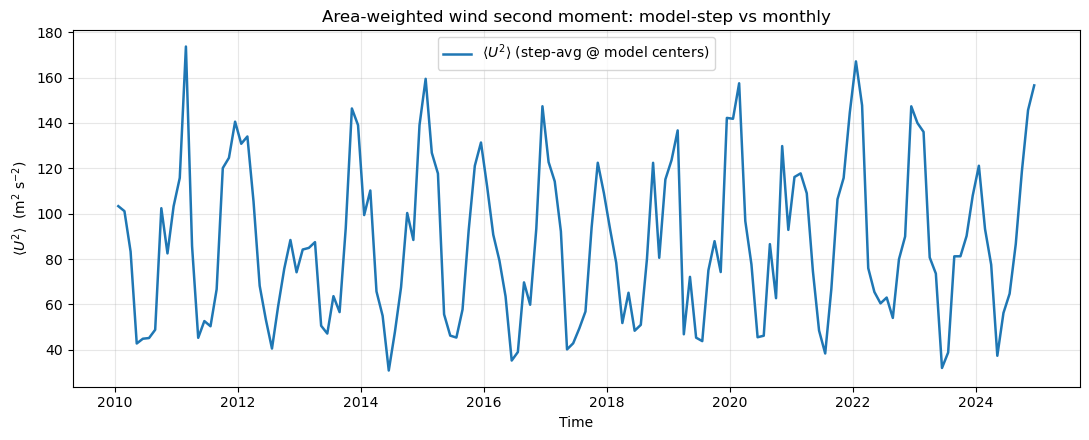

In [27]:
U2_file = DATA_INTERIM / f"U2_{region_name}.npy"

if U2_file.exists():
    print(f"Loading precomputed U2 from {U2_file}")
    U2_for_step = np.load(U2_file)
    print(f"Loaded {len(U2_for_step)} steps from cached file.")
else:
    print("No cached U2 found → computing …")
    nc_files = sorted([p for p in WIND_DIR.glob("*.nc*")])

    ds = xr.open_mfdataset(
        nc_files,
        combine="by_coords",
        chunks={"time": 8, "latitude": -1, "longitude": -1},
    )

    ds_box = subset_box_0360(ds, lon_min, lon_max, lat_min, lat_max, lon_name="longitude", lat_name="latitude")
    print(ds_box.sizes)
    print(float(ds_box.latitude.min()), "→", float(ds_box.latitude.max()))
    print(float(ds_box.longitude.min()), "→", float(ds_box.longitude.max()))

    U2_monthly = (ds_box["w"] ** 2).rename("U2")
    U2_monthly.attrs.update(units="m2 s-2", long_name="10 m wind second moment (monthly)")

    lat = U2_monthly["latitude"]
    weights_lat = np.cos(np.deg2rad(lat))
    weights_lat = weights_lat / weights_lat.mean()
    U2_monthly_wmean = (U2_monthly * weights_lat).mean(dim=("latitude", "longitude"))

    U2_step = U2_monthly_wmean.interp(time=centers)
    U2_step = U2_step.assign_coords(time=("time", centers))

    U2_for_step = U2_step.to_numpy()
    assert len(U2_for_step) == len(times) - 1, (len(U2_for_step), len(times)-1)

    np.save(U2_file, U2_for_step)
    print(f"Saved U2_for_step ({len(U2_for_step)} values) to {U2_file}")

plt.figure(figsize=(11, 4.5))
plt.plot(centers,U2_for_step,label=r"$\langle U^2 \rangle$ (step-avg @ model centers)", lw=1.8)
plt.title("Area-weighted wind second moment: model-step vs monthly")
plt.xlabel("Time")
plt.ylabel(r"$\langle U^2 \rangle$  (m$^2$ s$^{-2}$)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(IMG_DIR / f"U2_{region_name}.png", dpi=300)
plt.show()


# NPP

In [28]:
NPP_file = DATA_INTERIM / f"NPP_{mld_mode}_{region_name}.npy"
npp_nc   = DATA_RAW / f"cmems_npp_{region_name}.nc"

if NPP_file.exists():
    print(f"Loading cached NPP from {NPP_file}")
    NPP_for_step = np.load(NPP_file)
    print(f"Loaded {len(NPP_for_step)} steps.")
else:
    print("No cached NPP found → preparing NPP …") 
    ds_npp = xr.open_dataset(npp_nc)
    ds_npp = ds_npp.assign_coords(
        time = pd.DatetimeIndex(ds_npp["time"].values)
    )
    # turn h1 array into DataArray on model centers
    h1_da = xr.DataArray(h1, dims=["time"], coords={"time": centers})

    # interpolate h1 to npp times
    h1_on_npp_time = h1_da.interp(time=ds_npp["time"])

    # loop over time and integrate NPP from 0..h1_t for each timestamp
    npp_list = []
    for tt in ds_npp["time"].values:
        # current mixed layer depth for this month
        h1_t = float(h1_on_npp_time.sel(time=tt))

        # subset NPP from 0..h1_t (depth is positive downward)
        npp_0_h1_t = ds_npp["nppv"].sel(time=tt).sel(depth=slice(0, h1_t))

        # build dz for this subset based on its depth coordinate
        z = npp_0_h1_t["depth"].values  # 1D array
        zedges = np.zeros(z.size + 1)
        zedges[1:-1] = 0.5 * (z[1:] + z[:-1])
        zedges[0] = z[0] - (zedges[1] - z[0])
        zedges[-1] = z[-1] + (z[-1] - zedges[-2])
        # clip the edges so we don't integrate below h1_t
        zedges = np.clip(zedges, 0, h1_t)
        dz = np.maximum(np.diff(zedges), 0)
        dz_da = xr.DataArray(dz, dims=["depth"], coords={"depth": npp_0_h1_t["depth"]})

        # depth integration for that time step: (mg C m^-3 d^-1 * m = mg C m^-2 d^-1)
        npp_int_t = (npp_0_h1_t * dz_da).sum(dim="depth", skipna=True)

        # spatial mean over lat/lon
        npp_mean_t = npp_int_t.mean(dim=["latitude", "longitude"], skipna=True)

        # store with time index
        npp_list.append(npp_mean_t)

    # Stack list back into a time series DataArray
    NPP_mld_int = xr.concat(npp_list, dim="time")
    NPP_mld_int = NPP_mld_int.assign_coords(time=ds_npp["time"])

    # interpolate that to your model step centers
    NPP_step = NPP_mld_int.interp(time=centers)

    # materialize and cache
    NPP_for_step = NPP_step.to_numpy()  # mg C m^-2 d^-1
    np.save(NPP_file, NPP_for_step)

    print(f"Saved NPP_for_step ({len(NPP_for_step)} values) to {NPP_file}")


Loading cached NPP from C:\Users\siebert\Documents\Projekte\SEAO2CDR\rIAM\data\interim\NPP_static_mike_station.npy
Loaded 150 steps.


# SST

Loading cached SST from C:\Users\siebert\Documents\Projekte\SEAO2CDR\rIAM\data\interim\SST_mike_station.npy
Loaded 150 steps.


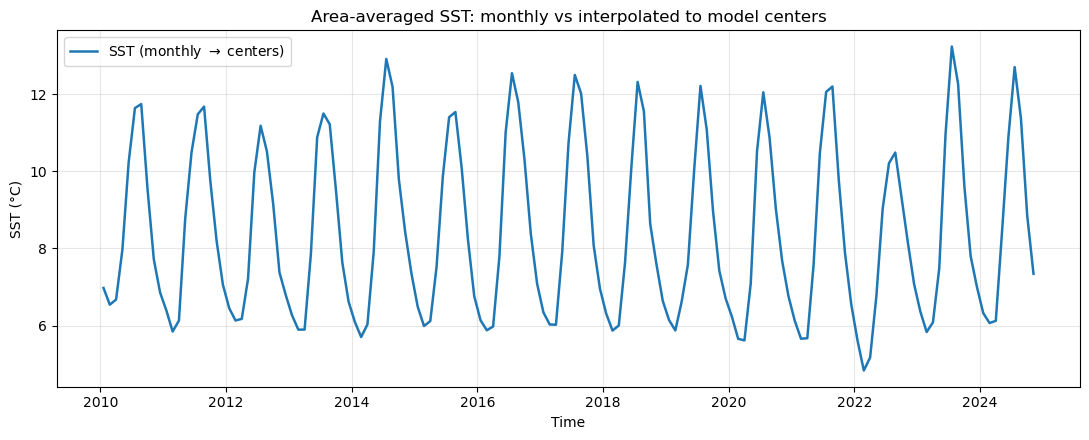

In [29]:
SST_file =  DATA_INTERIM / f"SST_{region_name}.npy"
sst_nc   = DATA_RAW / f"cmems_nws_sst_{region_name}.nc"

if SST_file.exists():
    print(f"Loading cached SST from {SST_file}")
    SST_for_step = np.load(SST_file)
    print(f"Loaded {len(SST_for_step)} steps.")
else:
    print("No cached SST found → preparing SST …")
    # Open and process to monthly regional mean (°C)
    ds_sst = xr.open_dataset(sst_nc)

    # Handle depth dimension
    sst_var = ds_sst["thetao"]
    if "depth" in sst_var.dims:
        sst_var = sst_var.sel(depth=0)

    # Spatial average over region
    sst_mean = sst_var.mean(dim=['latitude','longitude'], skipna=True)

    # Make time tz-naive and interpolate to your model step centers
    sst_mean = sst_mean.assign_coords(
        time=pd.DatetimeIndex(sst_mean["time"].values)
    )
    SST_step = sst_mean.interp(time=centers)

    # Materialize and cache
    SST_for_step = SST_step.to_numpy()   # °C
    assert len(SST_for_step) == len(times) - 1, (len(SST_for_step), len(times)-1)

    np.save(SST_file, SST_for_step)  # °C
    print(f"Saved SST_for_step ({len(SST_for_step)} values) to {SST_file}")

    # --- Plot SST over time: model-step vs native monthly -------------------------
plt.figure(figsize=(11, 4.5))

# 1) SST interpolated to model-step centers (°C)
plt.plot(
    centers,
    SST_for_step,
    lw=1.8,
    label=r"SST (monthly $\rightarrow$ centers)",
)

plt.title("Area-averaged SST: monthly vs interpolated to model centers")
plt.xlabel("Time")
plt.ylabel("SST (°C)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(IMG_DIR / f"SST_{region_name}.png", dpi=300)
plt.show()


# NCP

Saved NCP_for_step (150 values) to C:\Users\siebert\Documents\Projekte\SEAO2CDR\rIAM\data\interim\NCP_static_mike_station.npy


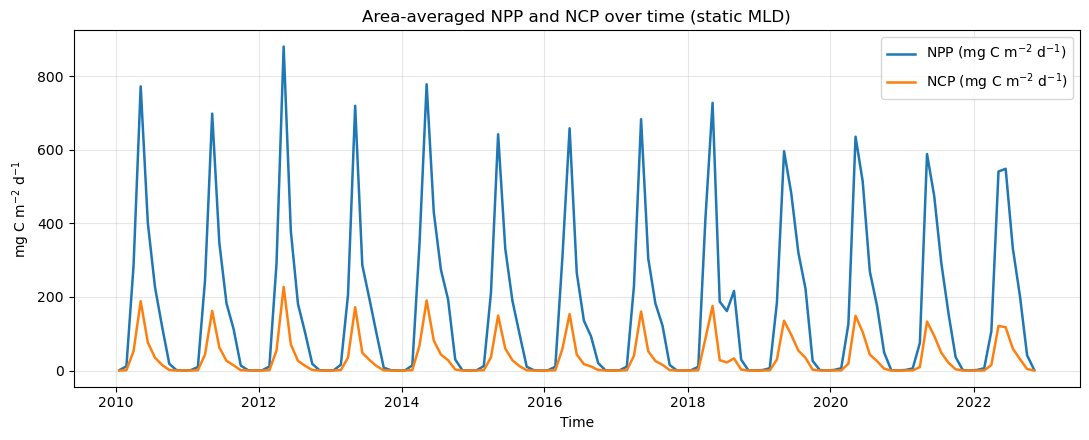

In [30]:
# --- EF- Ratio and NCP ---
NCP_file =  DATA_INTERIM / f"NCP_{mld_mode}_{region_name}.npy"
# NPP_for_step: array in mg C m^-2 d^-1 
# SST_for_step: array in °C (same timeline, interpolated to your step centers)

# clip tiny negatives to zero
NPP = np.clip(NPP_for_step, 0.0, None)   

# Laws (2011) Eq. 3:
ef = (0.78 - 0.43 * (SST_for_step / 30.0)) * (0.04756 * (NPP ** 0.307))


# NCP (mg C m^-2 d^-1)
NCP_for_step = NPP * ef


# unit conversion to µmol C kg⁻¹ yr⁻¹:
# rho = 1025.0  # kg m^-3
# mg m^-2 d^-1 → µmol m^-2 d^-1 (×1000/12)
# → µmol kg^-1 d^-1 by dividing by (rho*h1)
# → µmol kg^-1 yr^-1 by × DAYS_PER_YEAR
NCP_uM_kg_yr = NCP_for_step * (1000.0 / M_C) / (rho * h1) * DAYS_PER_YEAR # µmol C kg^-1 yr^-1

np.save(NCP_file, NCP_uM_kg_yr)  # °C
print(f"Saved NCP_for_step ({len(NCP_uM_kg_yr)} values) to {NCP_file}")

# plot NPP and NCP_for_step
plt.figure(figsize=(11, 4.5))
plt.plot(
    centers,
    NPP,
    lw=1.8,
    label=r"NPP (mg C m$^{-2}$ d$^{-1}$)",
)
plt.plot(
    centers,
    NCP_for_step,
    lw=1.8,
    label=r"NCP (mg C m$^{-2}$ d$^{-1}$)",
)
plt.title(f"Area-averaged NPP and NCP over time ({mld_mode} MLD)")
plt.xlabel("Time")
plt.ylabel("mg C m$^{-2}$ d$^{-1}$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(IMG_DIR / f"NPP_NCP_{mld_mode}_{region_name}.png", dpi=300)
plt.show()